In [1]:
#libaries
import numpy as np
import pandas as pd

import os
import tarfile
import urllib
from six.moves import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Allows feeding a pandas dataframe containing non-numerical values directly into a pipeline - drops them
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.attribute_names].values

    # Definition of the CategoricalEncoder class, copied from PR #9151.
    # Just run this cell, or copy it to your code, do not try to understand it (yet).

    from sklearn.base import BaseEstimator, TransformerMixin
    from sklearn.utils import check_array
    from sklearn.preprocessing import LabelEncoder
    from scipy import sparse
# Present in SKlearn .20 dev0
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [3]:
# read in the data: https://archive.ics.uci.edu/ml/datasets/Poker+Hand 
# suit (1-4)... Heart, Club, Diamond, Spade
# card (1-13)... Ace (low) – King
# hand (0-9) in increasing rank of quality
# HOUSING_PATH = os.path.join("datasets", "cards")
# HOUSING_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-testing.data"
# def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
#     if not os.path.isdir(housing_path):
#         os.makedirs(housing_path)
#     tgz_path = os.path.join(housing_path, "poker-hand-testing.data")
#     urllib.request.urlretrieve(housing_url, tgz_path)
#     housing_tgz = tarfile.open(tgz_path)
#     housing_tgz.extractall(path=housing_path)
#     housing_tgz.close()
    
# fetch_housing_data()   
poker = pd.read_csv('poker-hand-testing.data.txt')

# set column names
poker.columns = ['suit#1','rank#1', 'suit#2', 'rank#2', 'suit#3', 'rank#3', 'suit#4', 'rank#4', 'suit#5', 'rank#5', 'pokerhand']
poker.head()


,suit#1,rank#1,suit#2,rank#2,suit#3,rank#3,suit#4,rank#4,suit#5,rank#5,pokerhand
0,3,12,3,2,3,11,4,5,2,5,1
1,1,9,4,6,1,4,3,2,3,9,1
2,1,4,3,13,2,13,2,1,3,6,1
3,3,10,2,7,1,2,2,11,4,9,0
4,1,3,4,5,3,4,1,12,4,6,0


In [4]:
poker.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 11 columns):
suit#1       999999 non-null int64
rank#1       999999 non-null int64
suit#2       999999 non-null int64
rank#2       999999 non-null int64
suit#3       999999 non-null int64
rank#3       999999 non-null int64
suit#4       999999 non-null int64
rank#4       999999 non-null int64
suit#5       999999 non-null int64
rank#5       999999 non-null int64
pokerhand    999999 non-null int64
dtypes: int64(11)
memory usage: 83.9 MB


In [5]:
poker['pokerhand'].value_counts()

0    501208
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: pokerhand, dtype: int64

In [6]:
poker.describe()

,suit#1,rank#1,suit#2,rank#2,suit#3,rank#3,suit#4,rank#4,suit#5,rank#5,pokerhand
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,2.500495,6.997933,2.499895,7.006091,2.500872,6.998876,2.500394,7.002302,2.499452,6.989476,0.616903
std,1.117767,3.743371,1.118568,3.743478,1.118225,3.741891,1.117246,3.741270,1.118948,3.739893,0.773377
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,0.000000
50%,3.000000,7.000000,3.000000,7.000000,3.000000,7.000000,3.000000,7.000000,2.000000,7.000000,0.000000
75%,3.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,4.000000,10.000000,1.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,9.000000


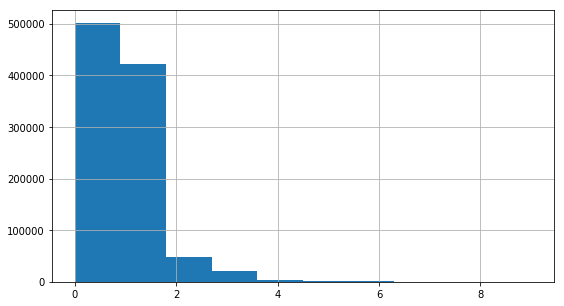

In [7]:
poker['pokerhand'].hist(figsize=(9,5))
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(poker, test_size=0.2, random_state=42)

In [9]:
#basically just shows random probability
corr = poker.corr()
corr.style.background_gradient()

,suit#1,rank#1,suit#2,rank#2,suit#3,rank#3,suit#4,rank#4,suit#5,rank#5,pokerhand
suit#1,1,-0.00145248,-0.021649,0.00121465,-0.0193359,0.000413277,-0.0192638,-6.07716e-05,-0.0189275,0.00154706,3.00093e-05
rank#1,-0.00145248,1,-0.000681532,-0.02151,-0.000134187,-0.0193912,-0.000118282,-0.0186585,0.000209703,-0.0210435,0.00387565
suit#2,-0.021649,-0.000681532,1,6.308e-05,-0.0191725,0.00096233,-0.0205121,-0.000119421,-0.0202073,0.00131066,-0.000195976
rank#2,0.00121465,-0.02151,6.308e-05,1,-0.00043736,-0.0208543,0.00153552,-0.0206818,-0.000637223,-0.0172768,0.00171235
suit#3,-0.0193359,-0.000134187,-0.0191725,-0.00043736,1,0.00109266,-0.0198255,0.000622672,-0.0206127,1.72576e-05,0.00119375
rank#3,0.000413277,-0.0193912,0.00096233,-0.0208543,0.00109266,1,-0.000176424,-0.0190302,0.00136026,-0.0203798,0.00248227
suit#4,-0.0192638,-0.000118282,-0.0205121,0.00153552,-0.0198255,-0.000176424,1,-0.000339698,-0.0194759,-0.000367334,-0.00115705
rank#4,-6.07716e-05,-0.0186585,-0.000119421,-0.0206818,0.000622672,-0.0190302,-0.000339698,1,0.000860493,-0.0207816,0.00300991
suit#5,-0.0189275,0.000209703,-0.0202073,-0.000637223,-0.0206127,0.00136026,-0.0194759,0.000860493,1,-8.597e-05,-0.00151525
rank#5,0.00154706,-0.0210435,0.00131066,-0.0172768,1.72576e-05,-0.0203798,-0.000367334,-0.0207816,-8.597e-05,1,0.00160433


In [10]:
print(corr["pokerhand"].sort_values(ascending=False))
cards = train_set.drop("pokerhand", axis=1)
cards_labels = train_set["pokerhand"].copy()
cards

pokerhand    1.000000
rank#1       0.003876
rank#4       0.003010
rank#3       0.002482
rank#2       0.001712
rank#5       0.001604
suit#3       0.001194
suit#1       0.000030
suit#2      -0.000196
suit#4      -0.001157
suit#5      -0.001515
Name: pokerhand, dtype: float64


,suit#1,rank#1,suit#2,rank#2,suit#3,rank#3,suit#4,rank#4,suit#5,rank#5
566853,4,13,3,7,4,8,2,3,2,4
382311,2,5,3,6,1,5,3,4,3,12
241519,4,3,4,4,4,13,2,8,3,2
930120,2,12,1,6,4,6,4,4,2,3
911069,4,6,4,3,2,6,2,2,3,9
259727,1,2,4,3,3,8,4,8,3,10
90029,1,5,3,4,1,13,3,12,2,5
529300,2,6,2,4,1,1,3,11,1,10
570430,1,4,4,6,3,2,1,9,1,12
720376,4,11,4,9,1,9,2,7,1,6


In [11]:
# Building custom datatype
temp = []
count = 0
for i,x in cards.iterrows():
    x=np.array(x)
    temp.append(len(np.unique(x[[0,2,4,6,8]])))
      

In [12]:
cards["unique"] = temp

In [13]:
cards

,suit#1,rank#1,suit#2,rank#2,suit#3,rank#3,suit#4,rank#4,suit#5,rank#5,unique
566853,4,13,3,7,4,8,2,3,2,4,3
382311,2,5,3,6,1,5,3,4,3,12,3
241519,4,3,4,4,4,13,2,8,3,2,3
930120,2,12,1,6,4,6,4,4,2,3,3
911069,4,6,4,3,2,6,2,2,3,9,3
259727,1,2,4,3,3,8,4,8,3,10,3
90029,1,5,3,4,1,13,3,12,2,5,3
529300,2,6,2,4,1,1,3,11,1,10,3
570430,1,4,4,6,3,2,1,9,1,12,3
720376,4,11,4,9,1,9,2,7,1,6,3


In [27]:
cat_attribs = ['suit#1','rank#1', 'suit#2', 'rank#2', 'suit#3', 'rank#3', 'suit#4', 'rank#4', 'suit#5', 'rank#5']
num_attribs = ["unique"]

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
])

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [28]:
cards_prepared = full_pipeline.fit_transform(cards)

In [30]:
type(cards_prepared)

numpy.ndarray

In [19]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(cards_prepared, cards_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [20]:
cards_predictions = tree_reg.predict(cards_prepared)
tree_mse = mean_squared_error(cards_labels, cards_predictions)
tree_rmse = np.sqrt(tree_mse)

In [21]:
tree_rmse #Hey we overfit lol 0.0

0.0

In [31]:
scores = cross_val_score(tree_reg, cards_prepared, cards_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

KeyboardInterrupt: 

In [ ]:
scores

In [ ]:
def display_scores(scores):
    # print("Scores:", scores)
    print("Mean:", scores.mean())
    print("STdev:", scores.std())

In [ ]:
display_scores(tree_rmse_scores) # 0.7335581073237469

In [ ]:
#Random Forest
forest_reg = RandomForestRegressor()
forest_reg.fit(cards_prepared, cards_labels)
scores = cross_val_score(forest_reg, cards_prepared, cards_labels, scoring="neg_mean_squared_error", cv=2)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores) # 0.5395899736067411

In [ ]:
#Grid Search
param_grid = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              }

forest_reg = RandomForestRegressor()
random_search = RandomizedSearchCV(forest_reg, param_grid, n_iter=20)
random_search.fit(cards_prepared, cards_labels)  # Doesn't retrain Forest_Reg
print("Best estimator: ", random_search.best_estimator_)

In [ ]:
randomized_forest_reg =RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=6, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [ ]:
scores = cross_val_score(randomized_forest_reg, cards_prepared, cards_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores) #0.5373603700940918

In [ ]:
param_grid = [  # 90 combinations
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', refit=True)
grid_search.fit(cards_prepared, cards_labels)  # Doesn't retrain Forest_Reg

print("Best estimator: ", grid_search.best_estimator_)

In [ ]:
grid_forest_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                   max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
                   min_impurity_split=None, min_samples_leaf=1,
                   min_samples_split=2, min_weight_fraction_leaf=0.0,
                   n_estimators=30, n_jobs=None, oob_score=False,
                   random_state=None, verbose=0, warm_start=False)

grid_forest_reg.fit(cards_prepared, cards_labels)
scores = cross_val_score(grid_forest_reg, cards_prepared, cards_labels, scoring="neg_mean_squared_error", cv=10)
grid_forest_rmse_scores = np.sqrt(-scores)
display_scores(grid_forest_rmse_scores)  # Best score Mean: 0.5121327242831755

In [ ]:
grid_forest_reg.predict(cards.iloc(0))

In [ ]:
cards[4,:]